# CS109B - Project - Milestone 3

### Sathish Angappan, Hannah Bend, Yohann Smadja

In this notebook, we will consider how we might tackle the general question of classifying a movie's genre as a next step towards our ultimate question: can a model predict genre based on poster images decade-to-decade? While our ultimate goal is to build a model using deep learning techniques, due to the size of the data and the memory required, we first will assess whether the general question of classification can be answered in the following more traditional methods:

1. Run PCA on grayscale, vectorized images
2. Run machine learning (KNN, LogReg, Random Forests) on reduced dimensions
3. Run machine learning (Naive) on word vectors from movie summaries

From there, we will discuss our findings as well as the challenges faced in building out these models and preparing for deep learning.

In [5]:
# Load useful libraries
import tmdbsimple as tmdb  # https://github.com/celiao/tmdbsimple/blob/master/tmdbsimple
import imdb as imdb
import wikipedia
import requests
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import time
from sklearn.decomposition import PCA
import PIL
from PIL import Image
import os
import urllib
import numpy as np
import matplotlib.image as mpimg
from sklearn.cross_validation import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import preprocessing, ensemble, preprocessing,cross_validation
from sklearn import svm
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer

# tmdb's key
tmdb.API_KEY = '594267d26bf6b98fd83b7bfd1729b426'  # Sathish's key

# 1. Preparing the data

We used the discover API below to retrieve movie data along with the poster information and stored it in a local data frame. Because of memory constraints, we retrieved only 300 movies released in the year 2016 that were categorized as one of our three major genres (Comedy, Action, Drama).

In [3]:
title = []
ids = []
release_date = []
popularity = []
genre_ids = []
vote_average = []
release_year = []
poster_path = []
overview = []
original_language = []

#Genre ID: 
drama = 18
discover = tmdb.Discover()
genres = [18,28,35]

for genre in genres:
    response = discover.movie(page = 1, primary_release_year=2016, with_genres=genre)
    no_of_pages = discover.total_pages
    for i in range(5):
        time.sleep(1)
        response = discover.movie(page = i+1, primary_release_year=2016, with_genres=genre)

        for k, s in zip(range(len(discover.results)), discover.results):
            title.append(s['title'])
            ids.append(s['id'])
            release_date.append(s['release_date'])
            popularity.append(s['popularity'])
            vote_average.append(s['vote_average'])
            genre_ids.append(genre)
            release_year.append(2016)
            poster_path.append(s['poster_path'])
            overview.append(s['overview'])
            original_language.append(s['original_language'])

df_all_movies = pd.DataFrame({'title': title, 'ids': ids, 'release_date': release_date, 'release_year' : release_year, 
                               'popularity': popularity, 'genre_ids': genre_ids, 'vote_average': vote_average, 
                              'poster_path': poster_path})

len(df_all_movies)

300

In [6]:
df_all_movies = pd.DataFrame({'title': title, 'ids': ids, 'release_date': release_date, 'release_year' : release_year, 
                               'popularity': popularity, 'genre_ids': genre_ids, 'vote_average': vote_average, 
                              'poster_path': poster_path, 'overview': overview, 'language': original_language})
df_all_movies.to_csv("300movies.csv", encoding='utf-8')

In [216]:
df_all_movies.head()

,genre_ids,ids,language,overview,popularity,poster_path,release_date,release_year,title,vote_average
0,18,335797,en,A koala named Buster recruits his best friend ...,66.294696,/s9ye87pvq2IaDvjv9x4IOXVjvA7.jpg,2016-11-23,2016,Sing,6.7
1,18,330459,en,A rogue band of resistance fighters unite for ...,34.246934,/qjiskwlV1qQzRCjpV0cL9pEMF9a.jpg,2016-12-14,2016,Rogue One: A Star Wars Story,7.3
2,18,382591,fr,A man without attachments or responsibilities ...,26.452999,/muwaDIv5cLv2Z07CZFWOsL7lYuO.jpg,2016-12-07,2016,Tomorrow Everything Starts,7.6
3,18,329865,en,Taking place after alien crafts land around th...,25.661950,/hLudzvGfpi6JlwUnsNhXwKKg4j.jpg,2016-11-10,2016,Arrival,6.9
4,18,313369,en,"Mia, an aspiring actress, serves lattes to mov...",25.362687,/ylXCdC106IKiarftHkcacasaAcb.jpg,2016-09-12,2016,La La Land,7.9


### 1.1 Challenge: Genre Imbalance

Since many movies are associated with multiple genres, some movies are retrieved more than once. For the purposes of this exercise, we will remove any duplicates that happened to pull in our random sample.  For the final model, we plan to execute a similar process, unless we come up with a better way of handling the imbalance in the meantime.

In [44]:
df_unique_movies = pd.read_csv('300movies.csv')
df_unique_movies = df_unique_movies.drop_duplicates(subset = ['ids'])
df_unique_movies.to_csv('unique_movies.csv', encoding='utf-8')

### 1.2 Downloading Poster Images

In [218]:
base_url = 'http://image.tmdb.org/t/p/original/'

def url2poster(movie):
    url = base_url+movie['poster_path']
    urllib.urlretrieve(url, './movie_posters/'+str(movie['ids'])+'_'+str(movie['genre_ids'])+".jpg")
    time.sleep(0.05)
    
df_unique_movies[pd.notnull(df_all_movies['poster_path'])].apply(url2poster, axis = 1)

C:\Users\i816717\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0      None
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
       ... 
266    None
267    None
268    None
269    None
270    None
271    None
272    None
274    None
275    None
277    None
278    None
279    None
280    None
281    None
282    None
283    None
284    None
287    None
288    None
289    None
290    None
291    None
292    None
293    None
294    None
295    None
296    None
297    None
298    None
299    None
dtype: object

In [45]:
images = os.listdir("./movie_posters")

### 1.3 Challenge: Standardizing, Color Washing and Vectorizing

Since every poster can have a different set of dimensions and different number of pixels, we need to standardize all the posters. We resized the images to 500 x 750 pixels using the following code.

In [ ]:
basewidth = 300
for img_jpg in images:
    img = Image.open('./movie_posters/' + str(img_jpg))
    #img = Image.open(base_url+'5vHssUeVe25bMrof1HyaPyWgaP.jpg')
    #wpercent = (basewidth/float(img.size[0]))
    #hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((500,750), PIL.Image.ANTIALIAS)
    img.save('./movie_posters_resized/'+str(img_jpg))

The downloaded images are in color and have RGB components, so the image arrays are 3-dimensional. For simplicity's sake, we converted the images to either greyscale or removed two of the RGB components. The following code removes two of the 3 components, leaving us with a 2D array.

In [46]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

img2 = mpimg.imread('./movie_posters_resized/95610_35.jpg')
print 'Image dimension before reducing the dimensions', img2.shape
print 'Image dimension after reducing the dimensions', rgb2gray(img2).shape

Image dimension before reducing the dimensions (750L, 500L, 3L)
Image dimension after reducing the dimensions (750L, 500L)


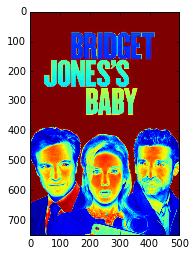

In [47]:
plt.imshow(rgb2gray(img2))
plt.show()

The image arrays need to be flattened into one dimension to incorporate into our models, so we reshaped them below.

In [48]:
image_vector = []
genres = []

for img_jpg in images:
    img = mpimg.imread('./movie_posters_resized/' + str(img_jpg))
    img_flat = (rgb2gray(img)).ravel()
    image_vector.append(img_flat.tolist())
    
    img_name = str(img_jpg).split('.')[0]
    genre = int(img_name.split('_')[1])
    genres.append(genre)
    
genres = np.array(genres)

In [49]:
np.array(image_vector).shape

(244L, 375000L)

As we see above, we have 244 images and the number of variables per image is 375000. This is a huge number of variables and running machine learning algorithms on such a huge dataset may not be possible. We need to reduce the dimensions by running PCA on the images.

# 2. Run PCA

We will use PCA to determine whether we can account for a significant portion of the variance with a reduced number of dimensions. To start, we ran it with 3 components to see how much variance they explained.

In [9]:
pca_images_3 = PCA(n_components = 3)
pca_images_3.fit(image_vector)
print (pca_images_3.transform(image_vector)).shape
print (pca_images_3.components_).shape

img_vct_reduced_3 = pca_images_3.transform(image_vector)
pca_images_3.explained_variance_ratio_

(244L, 3L)
(3L, 375000L)


array([ 0.29728014,  0.08133524,  0.05555378])

In [32]:
print 'Variance explained by 3 components: ', np.sum(pca_images_3.explained_variance_ratio_)

Variance explained by 3 components:  0.434169164867


In [28]:
#Apply PCA to data and get the top 2 axes of maximum variation
pca_images_2 = PCA(n_components=2)
pca_images_2.fit(image_vector)

#Project to the data onto the three axes
img_vct_reduced_2 = pca_images_2.transform(image_vector)

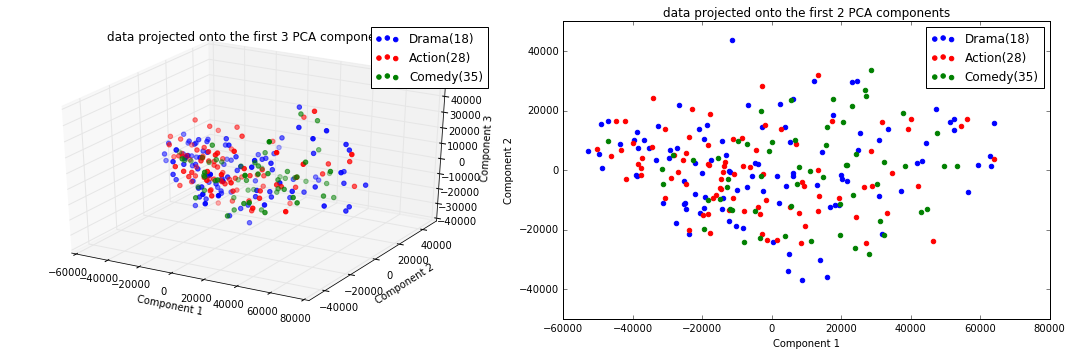

In [39]:
#Visualized our reduced data (n_components = 3)
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 2, 1,  projection='3d')
ax1.scatter(img_vct_reduced_3[genres==18, 0], img_vct_reduced_3[genres==18, 1], img_vct_reduced_3[genres==18, 2], c='b', color='b', label='Drama(18)')
ax1.scatter(img_vct_reduced_3[genres==28, 0], img_vct_reduced_3[genres==28, 1], img_vct_reduced_3[genres==28, 2], c='r', color='r', label='Action(28)')
ax1.scatter(img_vct_reduced_3[genres==35, 0], img_vct_reduced_3[genres==35, 1], img_vct_reduced_3[genres==35, 2], c='g', color='g', label='Comedy(35)')

ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_zlabel('Component 3')
ax1.set_title('data projected onto the first 3 PCA components')
ax1.legend(loc = 'best')

#Visualized our reduced data (n_components = 2)
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(img_vct_reduced_2[genres==18, 0], img_vct_reduced_2[genres==18, 1], c='b', color='b', label='Drama(18)')
ax2.scatter(img_vct_reduced_2[genres==28, 0], img_vct_reduced_2[genres==28, 1], c='r', color='r', label='Action(28)')
ax2.scatter(img_vct_reduced_2[genres==35, 0], img_vct_reduced_2[genres==35, 1], c='g', color='g', label='Comedy(35)')

ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_title('data projected onto the first 2 PCA components')
ax2.legend()

plt.tight_layout()
plt.show()

Visualizing the data with 3 components and then 2 components, there isn't much clustering or separation between genres, which is to be expected since we were only able to explain 43% of the variance with three components. We ran again, this time with 20 components to see how much that increased our percentage.

In [12]:
pca_images = PCA(n_components = 20)
img_vct_reduced = pca_images.fit_transform(image_vector)

In [13]:
print 'Original Image shape: ' , np.array(image_vector).shape
print 'Reduced shape after applying 20 components of PCA: ' , img_vct_reduced.shape

print 'Components: ' , (pca_images.components_).shape
print 'Explained Variance Ratio: ' , np.sum(pca_images.explained_variance_ratio_)

Original Image shape:  (244L, 375000L)
Reduced shape after applying 20 components of PCA:  (244L, 20L)
Components:  (20L, 375000L)
Explained Variance Ratio:  0.656834762667


20 components explain 65% of the variance in the data; we could continue increasing the number of components for more coverage, as 20 is still a minute fraction of the 375,000 variables we started with.  However, for the sake of time, we will move on with 20, setting up train/test datasets for our traditional models.

In [42]:
pca_df = pd.DataFrame(img_vct_reduced)
pca_df['genres'] = genres

pca_df.to_csv('images_pca.csv')
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,genres
0,-6216.893182,926.933788,-21473.467270,24970.167608,-14660.085036,6015.901817,2050.514573,-1209.734519,7451.533668,-6810.014832,...,-2504.595704,4596.589218,-5112.377570,246.322717,3163.901367,-2629.638862,-1115.288540,8040.330879,-3330.820070,28
1,-11432.675459,-13269.413786,-1.322662,2202.273132,10041.512039,-674.836431,5998.724770,-4301.744624,902.629848,2361.874690,...,425.518295,-2702.966859,-1467.197883,-2894.706789,-1703.729169,-99.629207,-536.579297,703.396983,931.021481,35
2,19413.062836,-9232.614540,-5099.377670,2772.561550,-1751.875031,10524.399538,-5837.896499,9945.566682,-12850.427870,-2409.344498,...,6644.775539,3799.732735,1358.965728,9068.961052,-982.982114,-7646.547346,-8495.898160,-3556.130354,6703.847538,28
3,9546.506689,-18926.476242,2738.264144,-27636.384227,-3008.457284,4248.990032,5443.783909,5339.665627,-2073.820816,4430.280685,...,-13373.356179,1531.326852,5417.225463,19852.673152,-11158.489923,1173.459308,10129.929638,9555.273977,-2407.868447,28
4,-28017.880095,5173.634269,2077.556410,12062.921178,3165.298577,-155.867398,2720.409493,-3111.670088,-1325.163898,6973.744057,...,3319.241010,-10100.657954,5307.352642,4339.552851,-2908.097663,-1925.929141,363.920806,3765.998084,4371.237909,28


In [14]:
x_train, x_test, y_train, y_test = train_test_split(img_vct_reduced, genres, test_size=0.40, random_state=0)

# 3. Run Image Models

In [21]:
#Fit a knn model on current year
knn = KNN()
    
#Create a logistic regression model with linear boundary
logreg = linear_model.LogisticRegression()

#Random Forest model with optimal feature set
rf = ensemble.RandomForestClassifier(n_estimators = 50, random_state = 42, 
                                                     max_features = 'sqrt', criterion = "gini")

#Supply Vector machines using Linear kernel
#svm_linear = svm.SVC(C = 1, kernel = 'linear')

In [24]:
#fit knn
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [22]:
#fit Logistic Regression
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
#fit Decision tree
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [25]:
#fit svm-linear
#svm_linear.fit(x_train, y_train)

We attempted to run SVM as well, but it was not able to compute, even with the reduced dimensions.  This is either because it was unable to fit a hyperplane separating the classes or we ran into memory/processor restrictions.  We will remove this from our analysis.

In [26]:
print logreg.score(x_test, y_test)
print knn.score(x_test, y_test)
print rf.score(x_test, y_test)
#print svm_linear.score(x_test, y_test)

0.377551020408
0.326530612245
0.336734693878


As seen above, none of the three traditional methods fared well in predicting genre.  Logistic Regression did the best of the three, but only by a small margin.  KNN we would have likely disregarded as model anyways as it's computation-heavy and our final model will have exponentially more data.  It would have been interesting to see whether a radial SVM was more succesful in predicting genre.

# 4. Run Keyword Models

Here, we extract keywords from movie overviews obtained from TMDB using a word vectorizer and then use those as our predictor variables.  But first, let's take a look at the keywords by genre.

In [10]:
df_unique_movies = pd.read_csv('unique_movies.csv')

genres = df_unique_movies['genre_ids']

#Create a text vectorizer (turns text into array of numbers)
#using a common list of English stop words
vectorizer = CountVectorizer(stop_words='english', min_df=1)

#Get all the text from data
corpus = df_unique_movies['overview'].values

#Turn each text into an array of word counts
x = vectorizer.fit_transform(corpus)
x = x.toarray()

#Get the names of all the words we're counting
feature_names = vectorizer.get_feature_names()

#We create a DataFrame of counts
df_counts = pd.DataFrame(x, columns = feature_names)

print 'data shape:', x.shape
print 'some features:', feature_names[0:10]

data shape: (244L, 3191L)
some features: [u'000', u'10', u'12', u'1206', u'133', u'15', u'155', u'15th', u'16', u'18']


In [54]:
np.array(feature_names).shape

(3191L,)

In [7]:
#Number of top words
n = 20

#Count the number of time each word occurs in the entire dataset
word_freq = x.sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

#Print the top n words and their frequencies
print top_words

[(47, u'life'), (45, u'new'), (43, u'world'), (28, u'story'), (27, u'man'), (26, u'family'), (22, u'young'), (21, u'finds'), (21, u'home'), (17, u'day'), (17, u'love'), (16, u'american'), (16, u'set'), (15, u'old'), (14, u'friends'), (14, u'help'), (13, u'dangerous'), (13, u'island'), (12, u'city'), (12, u'death')]


### 4.1 Visualizing Keywords

Across our 244 movies, the top word is "life", used 48 times, but interestingly when we look at the top 20 words by genre, it doesn't make any of the top lists.  Instead, we see a trend in the types of words associated with each genre, with several in drama implying calamity or intrigue.  Our next step will be to conduct a Naive Bayes classifier based on these word associations.

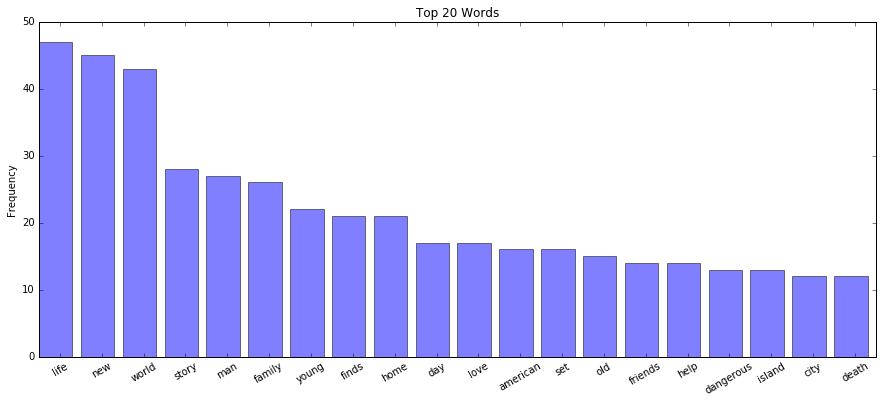

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

#Number of bars to use
indices = np.arange(n)
#Where to put the label under each bar
width = 0.5
#Bar plot of the frequencies of the top words
ax.bar(indices, [word[0] for word in top_words], color='blue', alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Top ' + str(n) + ' Words')

#Label the bars with the top words
ax.set_xticks(indices + width)
ax.set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

plt.show()

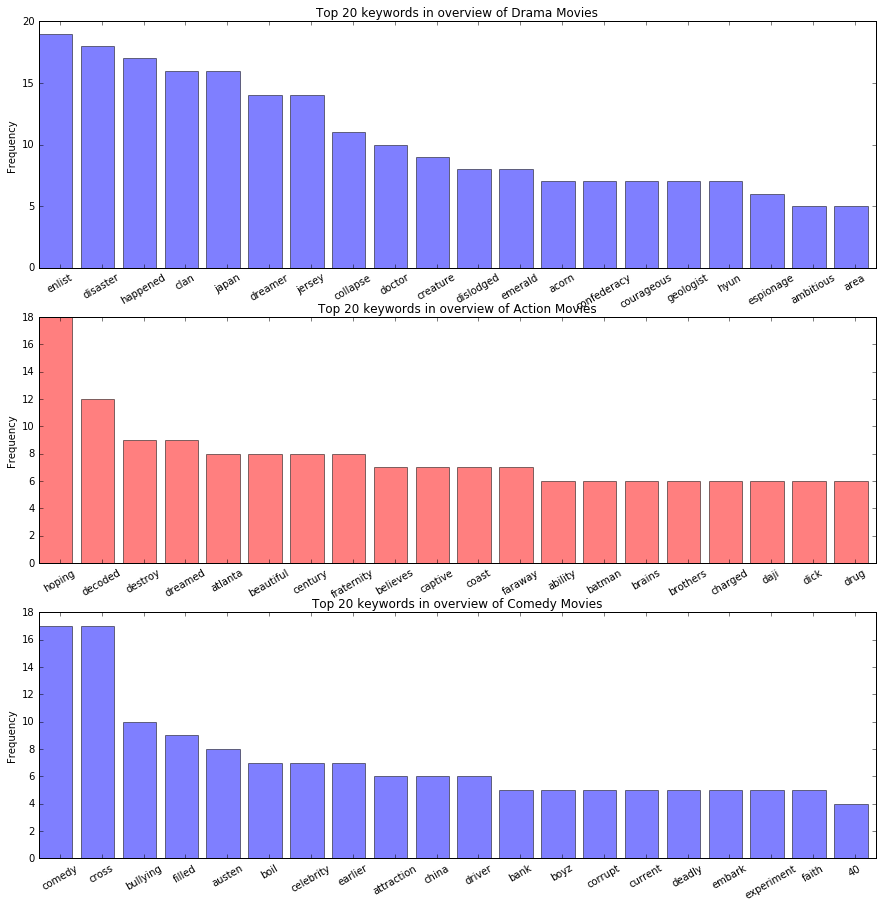

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
#Number of bars to use
indices = np.arange(n)
#Where to put the label under each bar
width = 0.5

def plot_keywords_by_genre(genre_id, plot_color, title, axis):
    #Get all the text from data
    corpus = df_unique_movies[(df_unique_movies['genre_ids'] == genre_id)]['overview'].values
    
    #Turn each text into an array of word counts
    x = vectorizer.fit_transform(corpus)
    x = x.toarray()
    
    #Count the number of time each word occurs in the positive posts
    word_freq = x.sum(axis=0)

    #Sort the words by their total frequency in the dataset
    words = zip(word_freq, feature_names)
    top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

    #Bar plot of the frequencies of the top words
    axis.bar(indices, [word[0] for word in top_words], color=plot_color, alpha=0.5)

    axis.set_ylabel('Frequency')
    axis.set_title('Top ' + str(n) + ' ' + title)

    #Label the bars with the top words
    axis.set_xticks(indices + width)
    axis.set_xticklabels([word[1] for word in top_words])

    #Turn the labels sideways so they don't overlap
    labels = axis.get_xticklabels()
    plt.setp(labels, rotation=30, fontsize=10)
    
plot_keywords_by_genre(18, 'blue', 'keywords in overview of Drama Movies', ax[0])
plot_keywords_by_genre(28, 'red', 'keywords in overview of Action Movies', ax[1])
plot_keywords_by_genre(35, 'blue', 'keywords in overview of Comedy Movies', ax[2])

plt.show()

### 4.2 Run Naive Bayes

In [11]:
# We create a DataFrame with the counts of the top 20 words
top_words_list = list(pd.DataFrame(top_words)[1])
df_counts_keys = df_counts[[i for i in top_words_list]]

from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_counts_keys, genres, test_size = 0.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

((195, 20), (49, 20), (195L,), (49L,))


Confusion matrix, without normalization
Overall accuracy:  0.49


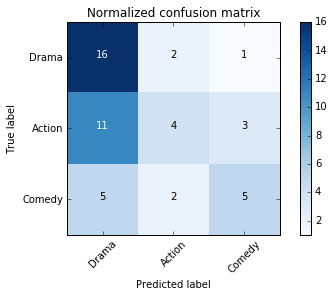

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import itertools

clf = MultinomialNB().fit(x_train, y_train)
y_pred = clf.predict(x_test)

class_names = ["Drama","Action","Comedy"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print "Overall accuracy: ", round(1-cm.trace()/(cm.sum()+0.0),3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Normalized confusion matrix')
plt.show()


A Naive Bayes classifier model on the top 20 words per genre returned an accuracy rate of 53.1%, better than our previous models did on images but still not great.  We tried increasing the word count to the top 100 to see if that improved our accuracy.

Confusion matrix, without normalization
Overall accuracy:  0.633


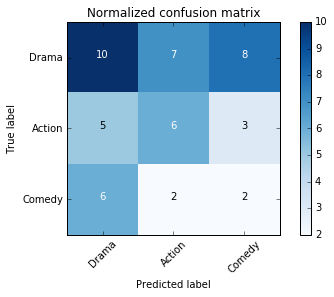

In [16]:
# We select 100 words this time
n = 100
word_freq = x.sum(axis=0)
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]
top_words_list = list(pd.DataFrame(top_words)[1])
df_counts_keys = df_counts[[i for i in top_words_list]]

# We fit a new model
x_train, x_test, y_train, y_test = train_test_split(df_counts_keys, genres, test_size = 0.2)
clf = MultinomialNB().fit(x_train, y_train)
y_pred = clf.predict(x_test)

# We print the results
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Normalized confusion matrix')
plt.show()


Increasing the word count to 100 improved our accuracy to 63%, but the first model did a much better job at distinguishing drama from the other two genres.  Generally, this indicates that Naive Bayes can be of tremendous help in our task to classify movies by genre. In this notebook, we only looked at 244 movies, only 20 and 100 key words from a very short movie description from TMDB. We are thinking about improving this model with wikipedia plots and training it on many more movies.

# 5. Challenge: Environments and CNN

We have started working on Deep Learning. Indeed, we ran a first convolution neural network and even though our network did not learn anything... we did!

We uploaded 200 posters onto an EC2 m4.large instance using FileZilla. Almost all the images have a 750 x 500 resolution but some had a slightly different one. We used matplotlib's resize function to make sure the resolution was exactly the same for all images. We were unable to use the load_img function from Keras as we kept getting an error message that the library PIL was missing despite successfull install and import. It does seem that the resolution is quite high and we should be able to reduce it to 500 by 350 or even further and not lose too much information.
For simplicity we started with only two classes. 100 of the posters were from action movies and the last 100 were dramas, ensuring the two classes were balanced. We split the dataset into two subsets: a training with 160 posters and a validation test with 40 of them. Obviously this is a very low number of inputs for such a complicated task to classify posters by genre but this is our very first model.

We then set up a small CNN model with 2 convolution layers, 2 max pool layers and one fully connected layer. Because of the size of the images, our model had 740,000 parameters to estimate. Our accuracy after 20 epochs was not better than the accuracy of a Naive model who would guess the genre randomly.

Setting up AWS and the Virtual Box has already required long hours from our entire team. Some instructions were unfortunately incomplete or not designed for Windows, Mac or Linux. Discovering those tools is part of the learning, but did limit our time spent on Milestone 3. However, we all feel ready now to tackle the Deep Learning part of the project!